In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import os
while 'notebooks' in os.getcwd():
    os.chdir('..')
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.stochastic_vol_tree import StochasticVolTree

## Defining parameters

## Stochastic volatility trees 


$$
V^{(n)} := \max_{\tau \in \mathcal{T}_n} \mathbb{E}^{(n)} \left( e^{-r \tau h} \left( K - S_0 e^{\hat{X}_\tau^{(n)}} \right)^+ \right)
$$




We describe a dynamical programming algorithm for the calculation of $V^{(n)}$. Observe that for a given $k \in \{0, \dots, n\}$, the random variables $X_k^{(n)}$ and $Y_k^{(n)}$ take values on the grid:

$$
x_0 + (2l - k) \sqrt{\eta h}, \quad 0 \leq l \leq k,
$$

and

$$
y_0 + (2m - k) \sqrt{\eta (1 - \rho^2) h}, \quad 0 \leq m \leq k,
$$

respectively. For nonnegative integers $m, l \leq k \leq n$ and $\xi_X, \xi_Y \in \{-1, +1\}$, let

$$
V_k^{(n)}(l, m, \xi_X, \xi_Y)
$$

be the value of the option at time $k$.

We continue by rewriting the dynamic programming equation in an algorithmic manner. In view of (3.11)–(3.13), for any $1 \leq k \leq n$ and $0 \leq l, m \leq k - 1$, we define:

$$
\mathcal{X}_k := x_0 + (2l - k) \sqrt{\eta h},
$$

$$
\mathcal{Y}_k := y_0 + (2m - k) \sqrt{\eta (1 - \rho^2) h},
$$

where both of the above are functions of $(l, m)$, but this dependence is suppressed in the notation. Similarly, we define two probabilities:

$$
p_k(l, m, \xi_X, \xi_Y) := \frac{\exp(rh + \sqrt{\eta h} \Psi_k l - \xi_X) - \exp(-\sqrt{\eta h} \Psi_k)}{\exp(\sqrt{\eta h} \Psi_k) - \exp(-\sqrt{\eta h} \Psi_k)},
$$

$$
q_k(l, m, \xi_X, \xi_Y) := \left( \min \left\{ 1, \frac{1}{2} + \frac{\alpha_{k-1}(l - \xi_X, m - \xi_Y)\xi_Y}{2 \Psi_k} + \frac{\sqrt{h} \mu_{y,k}}{2\sqrt{\eta (1 - \rho^2)} \Psi_k} \right\} \right)^+,
$$

where $\alpha_0^{(n)} \equiv 0$ and

$$
\alpha_k(l, m) := \frac{\max(A_n, \sigma^2(\mathcal{X}_{k-1}, \mathcal{Y}_{k-1})) - 1}{2},
$$

$$
\Psi_k := 1 + \alpha_k^{(n)}(l, m),
$$

$$
\mu_{y,k} := \mu_y(\mathcal{X}_{k-1}, \mathcal{Y}_{k-1}).
$$


We are now ready to restate the dynamic programming equation (5.1). Indeed, $V_k^{(n)}(l, m, \xi_X, \xi_Y)$ is the unique solution of the following recursive relations:

$$
V_n^{(n)}(l, m, \xi_X, \xi_Y) = \left( K - \exp \left( X_n + \sqrt{\eta h} \alpha_n \xi_X \right) \right)^+,
$$

and for $1 \leq k \leq n$,

$$
V_{k-1}^{(n)}(l, m, \xi_X, \xi_Y) = \max \left\{ \left( K - \exp \left( X_{k-1} + \sqrt{\eta h} \alpha_{k-1} \xi_X \right) \right)^+, \mathcal{E}(V_k^{(n)}) \right\},
$$

where $ \mathcal{E}(V_k^{(n)})$

is given by

$$
\mathcal{E}(V_k^{(n)}) = \mathbb{E}^{(n)} \left[ V_k^{(n)}(\Xi_k) \big| \Xi_{k-1} = F_{k-1}(l, m, \xi_X, \xi_Y) \right]
$$

and can be written as:

$$
\mathcal{E}(V_k^{(n)}) = \frac{1}{4} \sum_{i, j = 0}^1 \mathbb{P}_k^{(n)}(\xi_k^X = 2i - 1, \xi_k^Y = 2j - 1) V_k^{(n)}(l + i, m + j, 2i - 1, 2j - 1)
$$



## First calculation 

$$ 
K = 10, r = 0.1, \eta = 0.9, \kappa = 5.0, \theta = 0.16, \rho = 0.1, T = 0.25, \nu_0 = 0.25^2
$$ 

In [13]:
kappa = 5.0
K = 10
r = 0.1
eta = 0.9
theta = 0.16
rho = 0.1
T = 0.25
v0 = 0.25**2
S0 = 10
N = 150

params = {
    'kappa': kappa,
    'K': K,
    'r': r,
    'eta': eta ,
    'theta': theta,
    'rho': rho,
    'T' : T,
    'v0' : v0,
    'S0' : S0,
    'N': N
}

params['h'] = params['T']/params['N']
params['x0'] = np.log(params['S0'])
params['y0'] = params['v0']/params['eta'] - params['rho'] * params['x0']
params['A'] = (params['kappa']*params['theta']/params['eta'] - np.abs(params['rho'])*params['r'])*np.sqrt(params['h']/(params['eta']*(1-params['rho']**2)))

In [14]:
stoch_vol_tree = StochasticVolTree()
option_prices = {}

In [15]:
option_prices[S0] = []
for i in tqdm(range(1, N+3,3)):
    memo = {}
    params['N'] = i
    option_price = stoch_vol_tree(**params)

    option_prices[S0].append(option_price)
    

  0%|          | 0/51 [00:00<?, ?it/s]


AttributeError: 'dict' object has no attribute 'append'

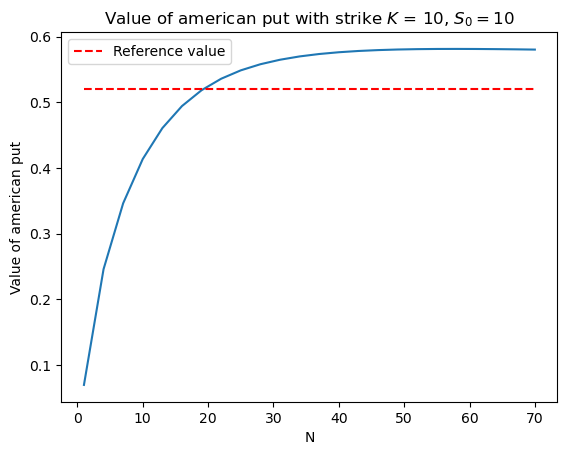

In [114]:
Ns = np.arange(1, N+3, 3)
plt.plot(Ns, option_prices[S0])
plt.hlines(0.52,Ns[0], Ns[-1], linestyles='dashed', colors='red', label='Reference value')
plt.xlabel('N')
plt.ylabel("Value of american put")
plt.title("Value of american put with strike $K$ = 10, $S_0 = 10$")
plt.legend()

$$ S_0  = 9$$

In [6]:
kappa = 5.0
K = 10
r = 0.1
eta = 0.9
theta = 0.16
rho = 0.1
T = 0.25
v0 = 0.25**2
S0 = 9
N = 70

params = {
    'kappa': kappa,
    'K': K,
    'r': r,
    'eta': eta ,
    'theta': theta,
    'rho': rho,
    'T' : T,
    'v0' : v0,
    'S0' : S0,
    'N': N
}

params['h'] = params['T']/params['N']
params['x0'] = np.log(params['S0'])
params['y0'] = params['v0']/params['eta'] - params['rho'] * params['x0']
params['A'] = (params['kappa']*params['theta']/params['eta'] - np.abs(params['rho'])*params['r'])*np.sqrt(params['h']/(params['eta']*(1-params['rho']**2)))

In [8]:
option_prices[S0] = []
for i in tqdm(range(1, N+3,3)):
    memo = {}
    params['N'] = i
    option_price = stoch_vol_tree(**params)

    option_prices[S0].append(option_price)
    

100%|██████████| 24/24 [09:49<00:00, 24.56s/it]


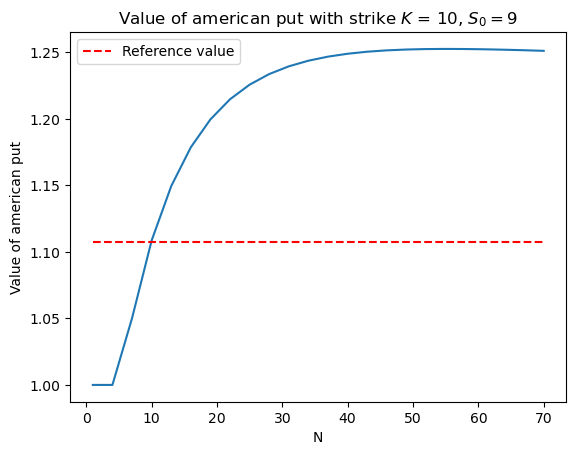

In [12]:
Ns = np.arange(1, N+3, 3)
plt.plot(Ns, option_prices[S0])
plt.hlines(1.1076 ,Ns[0], Ns[-1], linestyles='dashed', colors='red', label='Reference value')
plt.xlabel('N')
plt.ylabel("Value of american put")
plt.title("Value of american put with strike $K$ = 10, $S_0 = 9$")
plt.legend()

In [ ]:
kappa = 5.0
K = 10
r = 0.1
eta = 0.9
theta = 0.16
rho = 0.1
T = 0.25
v0 = 0.25**2
S0 = 9
N = 70

params = {
    'kappa': kappa,
    'K': K,
    'r': r,
    'eta': eta ,
    'theta': theta,
    'rho': rho,
    'T' : T,
    'v0' : v0,
    'S0' : S0,
    'N': N
}

params['h'] = params['T']/params['N']
params['x0'] = np.log(params['S0'])
params['y0'] = params['v0']/params['eta'] - params['rho'] * params['x0']
params['A'] = (params['kappa']*params['theta']/params['eta'] - np.abs(params['rho'])*params['r'])*np.sqrt(params['h']/(params['eta']*(1-params['rho']**2)))
option_prices[S0] = []
for i in tqdm(range(1, N+3,3)):
    memo = {}
    params['N'] = i
    option_price = stoch_vol_tree(**params)

    option_prices[S0].append(option_price)
    
Ns = np.arange(1, N+3, 3)
plt.plot(Ns, option_prices[S0])
plt.hlines(1.1076 ,Ns[0], Ns[-1], linestyles='dashed', colors='red', label='Reference value')
plt.xlabel('N')
plt.ylabel("Value of american put")
plt.title("Value of american put with strike $K$ = 10, $S_0 = 9$")
plt.legend()